# Lab 6: Mixture Models + Model order selection

# Mohamed Aymen Qabel

# Inès Florez de la Colina

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts.

You have to send the filled notebook named **"L4_6_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2020@gmail.com before November 28 at 23:59 and put **"AML-L4-6"** in the subject. 

We begin with the standard imports:

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from time import time

We will have two toy datasets to try the different methods:

# GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

# First part

Fill in the following class to implement a multivariate GMM:

In [2]:
class my_GMM():
    
    def __init__(self, k, initialization):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k_ = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        self.initialization_ = initialization
        
    def compute_condition_prob_matrix(self, X,k, alpha, mu, Sigma):
        '''Compute the conditional probability matrix 
        shape: (n, K)
        '''
        #Compute Probability matrix
        n, p = np.shape(X)
        proba_matrix = np.zeros((n,k))

        for i in range(k):
            proba_matrix[:,i] = multivariate_normal.pdf(X, mu[i], Sigma[:,:,i])
        proba_matrix = alpha*proba_matrix
        proba_matrix /= np.sum(proba_matrix, axis= 1, keepdims=True)
        #print(proba_matrix)
        return proba_matrix

    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        
        n, p = np.shape(X)
        self.cond_prob_ = np.zeros((n,self.k_))
        index_max = 0
        self.labels_ = np.zeros((n,1))
        iteration = 0
        
        #Initialisation
        if self.initialization_ == "kmeans":
            model = KMeans(self.k_)
            model.fit(X)
            self.mu_ = model.cluster_centers_
            self.alpha_ = np.unique(model.labels_, return_counts=True)[1]/n
            self.Sigma_ = np.zeros((p,p,self.k_))
            
            #initialize sigma using the usual estimator for the covariance matrix
            for i in range(self.k_):
                X_mu = X[model.labels_ == i] - self.mu_[i]
                number_i = np.shape(X_mu)[0]
                self.Sigma_[:,:,i] = np.dot(X_mu.T, X_mu)/number_i
            
                
        elif self.initialization_ == "random":
            self.mu_ = np.random.rand(self.k_, p)
            self.alpha_ = np.ones(self.k_)/self.k_
            self.Sigma_ = np.repeat(np.eye(p)[:,:,None],self.k_, axis=2) 

        else:
            return "Wrong initialization, please initialize with kmeans or random"
        
        #Implement the EM algorithm
        eps = 1e-4
        norm_dif = 1
        converge = False
        
        #while norm_dif > eps:
        while not(converge):
            
            #keeping the values from the previous iteration for convergence
            old_mu = self.mu_
            old_sigma = self.Sigma_
            old_prop = self.alpha_
            
            #compute the condition probability matrix
            self.cond_prob_ = self.compute_condition_prob_matrix(X,self.k_, self.alpha_, self.mu_, self.Sigma_)
            
            #compute the new parameters
            self.alpha_ = np.mean(self.cond_prob_, axis=0)
            self.mu_ = np.dot(self.cond_prob_.T, X)/(self.alpha_[:, None]*n)
            self.Sigma_ = np.zeros((p,p,self.k_))
            for i in range(self.k_):
                X_mu_new = X - self.mu_[i]
                self.Sigma_[:,:,i] = np.dot(X_mu_new.T, (self.cond_prob_[:,[i]]*X_mu_new))/(self.alpha_[i])
                #sigma_t[:,:,i] = np.dot((X - mu_t[i]).T, (cond_prob[:,[i]]*(X - mu_t[i])))/prob_k_t[i]
            self.Sigma_ /= n
                
            #check for convergence
            sigma_dif = np.isclose(self.Sigma_, old_sigma, rtol= 1e-4, atol=0).all()
            mu_dif = np.isclose(self.mu_, old_mu, rtol= 1e-4, atol=0).all()
            prop_dif = np.isclose(self.alpha_, old_prop, rtol= 1e-4, atol=0).all()
            converge = mu_dif*sigma_dif*prop_dif
            iteration += 1
            
        
        # Update_labels_
        self.labels_ = np.argmax(self.compute_condition_prob_matrix(X,self.k_, self.alpha_, self.mu_, self.Sigma_), axis=1)

        # Return self
        return self

        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment  
        """
        return np.argmax(self.compute_condition_prob_matrix(X,self.k_, self.alpha_, self.mu_, self.Sigma_), axis=1)
    
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        probabilities = self.compute_condition_prob_matrix(X,self.k_, self.mu_, self.Sigma_, self.alpha_)
        return probabilities

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

### Simulations for testing the EM Algorithm

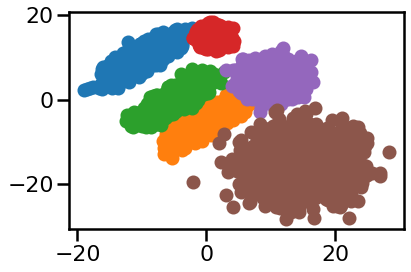

In [87]:
mu = np.array([[-10,10],[0,-5],[-5,0],[1,15],[10,5],[15,-15]])
sigma = np.zeros((2,2,6))
std_0 = np.array([[1,2],[2,1]])
std_1 = np.array([[1,2],[2,1]])
std_2 = np.array([[1,2],[2,1]])
std_3 = np.eye(2)
std_4 = 2*np.eye(2)
std_5 = 4*np.eye(2)
var_0, var_1, var_2, var_3, var_4, var_5 = std_0.T@std_0, std_1.T@std_1, std_2.T@std_2, std_3.T@std_3, std_4.T@std_4, std_5.T@std_5
sigma[:,:,0], sigma[:,:,1], sigma[:,:,2], sigma[:,:,3], sigma[:,:,4], sigma[:,:,5] = var_0, var_1, var_2, var_3, var_4, var_5


X_1 = np.random.multivariate_normal(mu[0], sigma[:,:,0], 2000)
X_2 = np.random.multivariate_normal(mu[1], sigma[:,:,1], 2000)
X_3 = np.random.multivariate_normal(mu[2], sigma[:,:,2], 2000)
X_4 = np.random.multivariate_normal(mu[3], sigma[:,:,3], 2000)
X_5 = np.random.multivariate_normal(mu[4], sigma[:,:,4], 2000)
X_6 = np.random.multivariate_normal(mu[5], sigma[:,:,5], 2000)

Y = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
x, y = Y[:,0], Y[:,1]

plt.scatter(X_1[:,0], X_1[:,1])
plt.scatter(X_2[:,0], X_2[:,1])
plt.scatter(X_3[:,0], X_3[:,1])
plt.scatter(X_4[:,0], X_4[:,1])
plt.scatter(X_5[:,0], X_5[:,1])
plt.scatter(X_6[:,0], X_6[:,1])
plt.show()

### Testing for the kmeans initialization

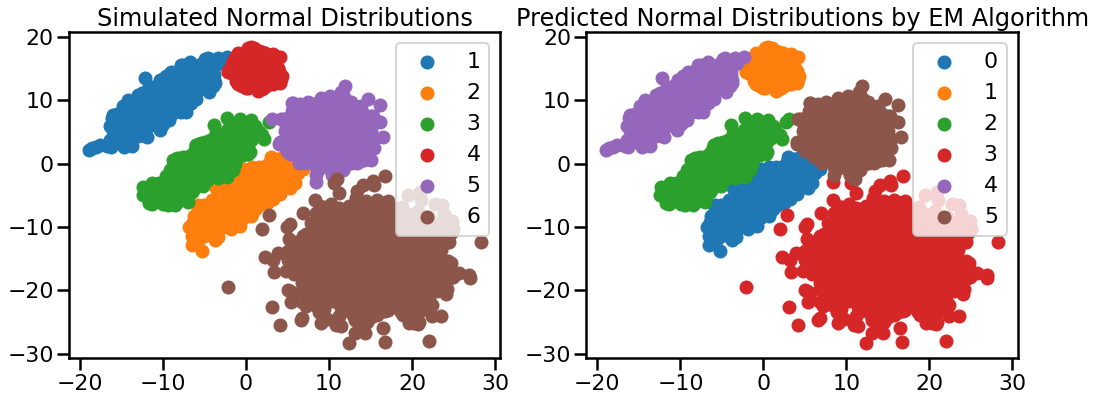

In [88]:
GMM = my_GMM(k=6, initialization = "kmeans")
GMM.fit(Y)
gmm_labels = GMM.labels_

fig, ax = plt.subplots(1,2, figsize=(17,6))

ax[0].scatter(X_1[:,0], X_1[:,1], label = 1)
ax[0].scatter(X_2[:,0], X_2[:,1], label = 2)
ax[0].scatter(X_3[:,0], X_3[:,1], label = 3)
ax[0].scatter(X_4[:,0], X_4[:,1], label = 4)
ax[0].scatter(X_5[:,0], X_5[:,1], label = 5)
ax[0].scatter(X_6[:,0], X_6[:,1], label = 6)
ax[0].legend()
ax[0].title.set_text('Simulated Normal Distributions')

for g in np.unique(gmm_labels):
    ix = np.where(gmm_labels== g)
    ax[1].scatter(x[ix], y[ix], label=g)
    ax[1].legend()
ax[1].title.set_text('Predicted Normal Distributions by EM Algorithm')

### Testing for Random Initialization

The number of iterations of the EM algorithm for 6 clusters is: 690


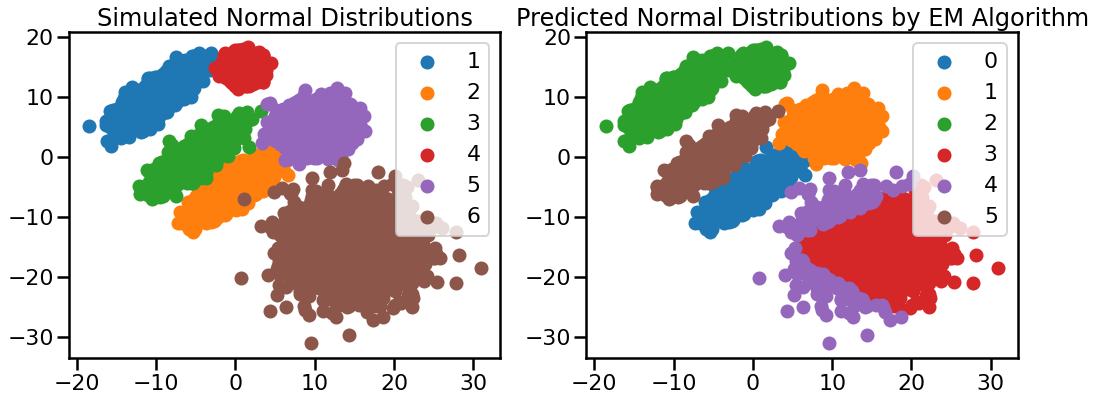

In [5]:
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

GMM = my_GMM(k=6, initialization = "random")
GMM.fit(Y)
gmm_labels = GMM.labels_

fig, ax = plt.subplots(1,2, figsize=(17,6))

ax[0].scatter(X_1[:,0], X_1[:,1], label = 1)
ax[0].scatter(X_2[:,0], X_2[:,1], label = 2)
ax[0].scatter(X_3[:,0], X_3[:,1], label = 3)
ax[0].scatter(X_4[:,0], X_4[:,1], label = 4)
ax[0].scatter(X_5[:,0], X_5[:,1], label = 5)
ax[0].scatter(X_6[:,0], X_6[:,1], label = 6)
ax[0].legend()
ax[0].title.set_text('Simulated Normal Distributions')

for g in np.unique(gmm_labels):
    ix = np.where(gmm_labels== g)
    ax[1].scatter(x[ix], y[ix], label=g)
    ax[1].legend()
ax[1].title.set_text('Predicted Normal Distributions by EM Algorithm')


# Second Part
 
- Select the number of clusters using the model order selection methods from the lecture (AIC, BIC)

## AIC and BIC

### Implementation of the AIC and BIC Criteria

In [132]:
def loglikelihood(mu, sigma, alpha, X):
    n, p = X.shape
    k, p = mu.shape
    log_likelihood = np.zeros((k,n))
    for i in range(k):
        log_likelihood[i] = alpha[i]*multivariate_normal.pdf(X, mu[i], sigma[:,:,i])
    log_likelihood = np.sum(log_likelihood, axis = 0)
    log_likelihood = np.log(log_likelihood)
    log_likelihood = np.sum(log_likelihood, axis = 0)
    return log_likelihood

def nb_params_AIC(k, X):
    n, p = X.shape
    return k*p + p*p*k + k

def nb_params_BIC(k, X):
    n, p = X.shape
    return 0.5*(k*p + p*p*k + k)*np.log(n)

def AIC_criterion(mu, sigma, alpha, X):
    k, p = mu.shape
    return nb_params_AIC(k, X) - loglikelihood(mu, sigma, alpha, X)

def BIC_criterion(mu, sigma, alpha, X):
    k, p = mu.shape
    return nb_params_BIC(k, X) - loglikelihood(mu, sigma, alpha, X)    

### Testing using AIC Criterion

#### Kmeans Initialization

The value of the AIC for 1 clusters is AIC = 86278.43567460055
The value of the AIC for 2 clusters is AIC = 84190.5230514032
The value of the AIC for 3 clusters is AIC = 78842.59060227852
The value of the AIC for 4 clusters is AIC = 75989.65279787612
The value of the AIC for 5 clusters is AIC = 72820.70325851292
The value of the AIC for 6 clusters is AIC = 70429.13748566865
The value of the AIC for 7 clusters is AIC = 70428.34015797684
The value of the AIC for 8 clusters is AIC = 70433.32354723524
The value of the AIC for 9 clusters is AIC = 70430.33615406009
The value of the AIC for 10 clusters is AIC = 70431.87932971094


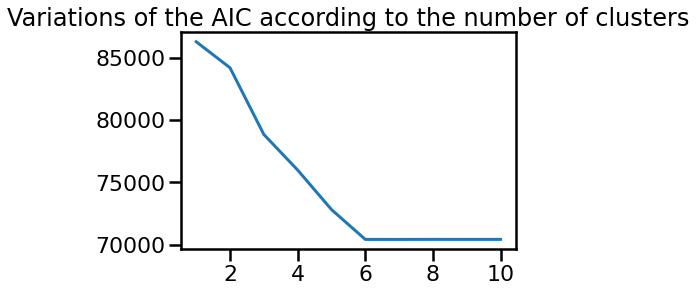

The best value of the AIC is: 70428.34015797684which corresponds to 7 clusters


In [38]:
AIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "kmeans")
    GMM.fit(Y)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    AIC = AIC_criterion(mu, Sigma, alpha, Y)
    print('The value of the AIC for ' + str(l)+ ' clusters is AIC = '+ str(AIC))
    AIC_crit.append(AIC)
    
plt.plot([i for i in range(1, len(AIC_crit)+1)], AIC_crit)
plt.title('Variations of the AIC according to the number of clusters')
plt.show()
AIC_best = min(AIC_crit)
print('The best value of the AIC is: ' + str(AIC_best) + 'which corresponds to ' + str(AIC_crit.index(AIC_best)+1) + ' clusters')

#### Random Initialization

The value of the AIC for 1 clusters is AIC = 86278.43567460055
The value of the AIC for 2 clusters is AIC = 83313.93772772743
The value of the AIC for 3 clusters is AIC = 78976.249063947
The value of the AIC for 4 clusters is AIC = 75989.65279789371
The value of the AIC for 5 clusters is AIC = 73617.47368897943
The value of the AIC for 6 clusters is AIC = 70429.13748566862
The value of the AIC for 7 clusters is AIC = 70431.8579525484
The value of the AIC for 8 clusters is AIC = 70432.62835503841
The value of the AIC for 9 clusters is AIC = 70431.93930072905
The value of the AIC for 10 clusters is AIC = 70433.05179402004


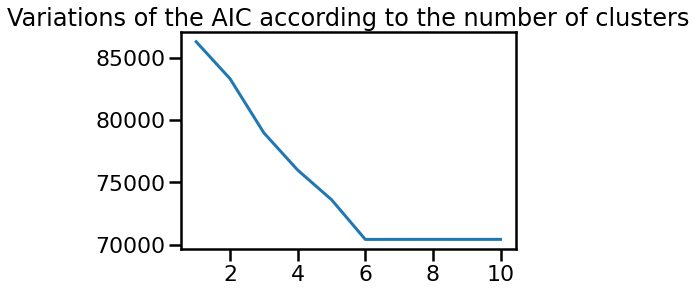

The best value of the AIC is: 70429.13748566862which corresponds to 6 clusters


In [36]:
AIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "random")
    GMM.fit(Y)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    AIC = AIC_criterion(mu, Sigma, alpha, Y)
    print('The value of the AIC for ' + str(l)+ ' clusters is AIC = '+ str(AIC))
    AIC_crit.append(AIC)
    
plt.plot([i for i in range(1, len(AIC_crit)+1)], AIC_crit)
plt.title('Variations of the AIC according to the number of clusters')
plt.show()
AIC_best = min(AIC_crit)
print('The best value of the AIC is: ' + str(AIC_best) + 'which corresponds to ' + str(AIC_crit.index(AIC_best)+1) + ' clusters')

According to the two graphs above, we can see that the AIC criterion gives the exact number of clusters for the random initialization and one cluster more with the kmeans one. Kmeans is obviously a better initialization as it already does a clustering that will be improved by the EM algorithm. The AIC takes into account the log-likelihood and the complexity of the model. Thus the AIC selected the right model.

### Testing using BIC criterion

#### Kmeans Initialization

The value of the BIC for 1 clusters is BIC = 86304.30999135124
The value of the BIC for 2 clusters is BIC = 84242.27168490134
The value of the BIC for 3 clusters is BIC = 78920.21355253064
The value of the BIC for 4 clusters is BIC = 76093.15006487868
The value of the BIC for 5 clusters is BIC = 72950.07484226642
The value of the BIC for 6 clusters is BIC = 70584.38338617282
The value of the BIC for 7 clusters is BIC = 70609.46037523041
The value of the BIC for 8 clusters is BIC = 70641.9922789513
The value of the BIC for 9 clusters is BIC = 70672.70620374082
The value of the BIC for 10 clusters is BIC = 70690.53335358668


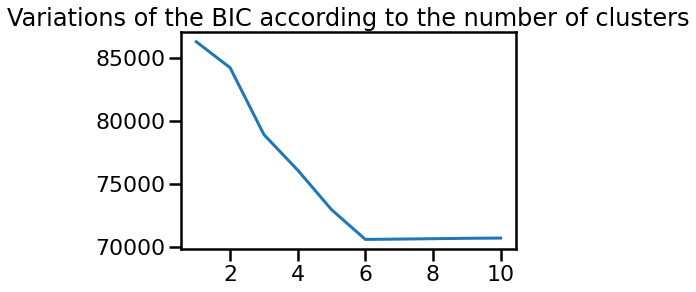

The best value of the BIC is: 70584.38338617282which corresponds to 6 clusters


In [44]:
BIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "kmeans")
    GMM.fit(Y)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    BIC = BIC_criterion(mu, Sigma, alpha, Y)
    print('The value of the BIC for ' + str(l)+ ' clusters is BIC = '+ str(BIC))
    BIC_crit.append(BIC)
    
plt.plot([i for i in range(1, len(BIC_crit)+1)], BIC_crit)
plt.title('Variations of the BIC according to the number of clusters')
plt.show()
BIC_best = min(BIC_crit)
print('The best value of the BIC is: ' + str(BIC_best) + 'which corresponds to ' + str(BIC_crit.index(BIC_best)+1) + ' clusters')

#### Random Initialization

The value of the BIC for 1 clusters is BIC = 86304.30999135124
The value of the BIC for 2 clusters is BIC = 82051.80364466131
The value of the BIC for 3 clusters is BIC = 79053.87201248121
The value of the BIC for 4 clusters is BIC = 76883.51654590292
The value of the BIC for 5 clusters is BIC = 74326.18210660235
The value of the BIC for 6 clusters is BIC = 70584.38338617282
The value of the BIC for 7 clusters is BIC = 70612.26765263944
The value of the BIC for 8 clusters is BIC = 70637.1222989883
The value of the BIC for 9 clusters is BIC = 70663.29360308373
The value of the BIC for 10 clusters is BIC = 70698.25459963708


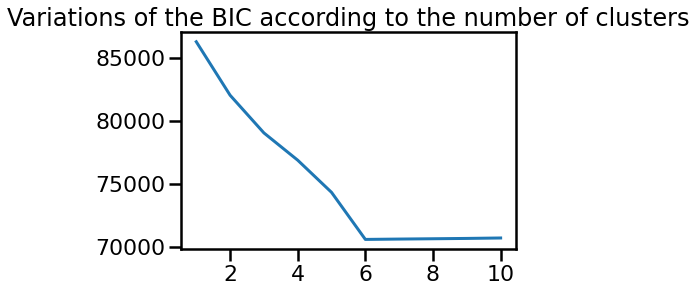

The best value of the BIC is: 70584.38338617282which corresponds to 6 clusters


In [45]:
BIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "random")
    GMM.fit(Y)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    BIC = BIC_criterion(mu, Sigma, alpha, Y)
    print('The value of the BIC for ' + str(l)+ ' clusters is BIC = '+ str(BIC))
    BIC_crit.append(BIC)
    
plt.plot([i for i in range(1, len(BIC_crit)+1)], BIC_crit)
plt.title('Variations of the BIC according to the number of clusters')
plt.show()
BIC_best = min(BIC_crit)
print('The best value of the BIC is: ' + str(BIC_best) + 'which corresponds to ' + str(BIC_crit.index(BIC_best)+1) + ' clusters')

Similaraly to the AIC, the BIC is going to take into account the log-likelihood and the complexity of the model also adding a penalization of log(N) where N is the number of samples. The BIC selects the right model as well with 6 clusters.

- Select the number of clusters using the model order reduction methods from the lecture (distance, correlation and parameter criteria)

## Order Reduction Methods

In [26]:
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean


def moder_order_selection(X, gmm ,eps, K=10, criterion = 'correlation'):
    mu = gmm.mu_
    sigma = gmm.Sigma_
    pi = gmm.alpha_
    n, p = X.shape
    num_clusters = K
    cond_matrix = gmm.cond_prob_
    list_indices=[]
    label  = gmm.labels_
    for i in range(num_clusters-1):
        for j in range(i+1,num_clusters):
            list_indices.append((i,j))
    while len(list_indices)>0:
        i,j = list_indices.pop()
        #changer = False
        cluster_1 = cond_matrix[:,i]
        cluster_2 = cond_matrix[:,j]
        n_1=n*pi[i]
        n_2=n*pi[j]
        mu_1=mu[i]
        mu_2=mu[j]
        sigma_1=sigma[:,:,i]
        sigma_2=sigma[:,:,j]
        if criterion == 'correlation':
            a = abs(pearsonr(cluster_1, cluster_2)[0])
            if a>=1-eps:
                criteria=True
            else:
                criteria=False
        if criterion == 'distance':
            a = euclidean(mu_1,mu_2)
            if a <= eps:
                criteria = True
            else:
                criteria= False
        if criterion == 'parameter':
            arr1 = X[np.where(label==i)]
            arr2 = X[np.where(label==j)]
            new_array = np.concatenate((arr1,arr2))
            dk_1 = np.var(arr1)
            dk_2 = np.var(arr2)
            dk_new = np.var(new_array)
            if dk_1+dk_2-eps>dk_new:
                criteria = True
            else:
                criteria = False
        if criteria:
            num_clusters-=1
            
            pi_new=pi[i]+pi[j]
            
            mu_new=(n_1*mu_1+n_2*mu_2)/(n_1+n_2)
            sigma_new=(n_1*sigma_1+n_2*sigma_2)/(n_1+n_2)
            # on crée de nouveaux tableaux:
            pi=np.delete(pi,[i,j])
            mu = np.delete(mu,[i,j], axis = 0)
            sigma=np.delete(sigma,[i,j], axis=2)
            pi = np.append(pi,pi_new)
            mu = np.insert(mu,num_clusters-1,mu_new, axis = 0)
            sigma = np.insert(sigma,num_clusters-1, sigma_new, axis = 2)  
            cond_matrix = gmm.compute_condition_prob_matrix(X,num_clusters,pi,mu,sigma)
            list_indices=[]
            for i in range(num_clusters-1):
                for j in range(i+1,num_clusters):
                    list_indices.append((i,j))
            label = np.argmax(cond_matrix, axis=1)
        
    return label

According to the following of the lab, we have seen that model order reduction is not very useful because the number of clusters this technique predicts fully depends on the chosen epsilon. And epsilon varies from one dataset to the other. To determine epsilon, we need prior information on the exact number of clusters of the dataset.

Do these two methods (order selection and reduction) agree on the final number of clusters for the two given datasets (data-MM-i.csv)? Does it make sense?

Compare the results and the computational time. Try to visually validate your results.

Comment. 

## Testing on the Given Datasets

### Data_MM_1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C1      1000 non-null   float64
 1   C2      1000 non-null   float64
 2   C3      1000 non-null   float64
dtypes: float64(3)
memory usage: 23.6 KB
None


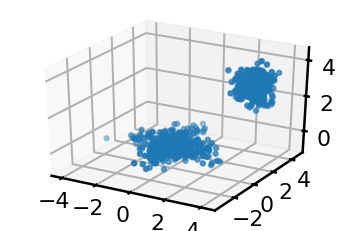

In [21]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
data_MM_1 = pd.read_csv('data_MM_1.csv', names = ['C1', 'C2', 'C3'])
print(data_MM_1.info())
threedee = plt.figure().gca(projection='3d')
threedee.scatter(data_MM_1['C1'], data_MM_1['C2'], data_MM_1['C3'])
plt.show()

In [22]:
X_model_1 = data_MM_1[["C1", "C2", "C3"]].to_numpy() 
print(X_model_1)
n, p = X_model_1.shape

[[-0.25233983 -0.65697213 -0.26435481]
 [ 2.48215483  2.62576715  3.18681239]
 [ 3.2899495   3.12791594  4.32237293]
 ...
 [ 2.94410401  2.78115907  2.48151659]
 [ 3.18502503  2.80503261  3.94432179]
 [-0.283677    1.29097357 -0.51458309]]


#### AIC Criterion Tests

The value of the AIC for 1 clusters is AIC = 4107.954897310745
The value of the AIC for 2 clusters is AIC = 2994.702448656834
The value of the AIC for 3 clusters is AIC = 2842.708559027076
The value of the AIC for 4 clusters is AIC = 2843.672781100472
The value of the AIC for 5 clusters is AIC = 2851.754447985143
The value of the AIC for 6 clusters is AIC = 2861.3290091524586
The value of the AIC for 7 clusters is AIC = 2865.2397018660076
The value of the AIC for 8 clusters is AIC = 2858.4997112311344
The value of the AIC for 9 clusters is AIC = 2876.0538431019813
The value of the AIC for 10 clusters is AIC = 2869.392297220661


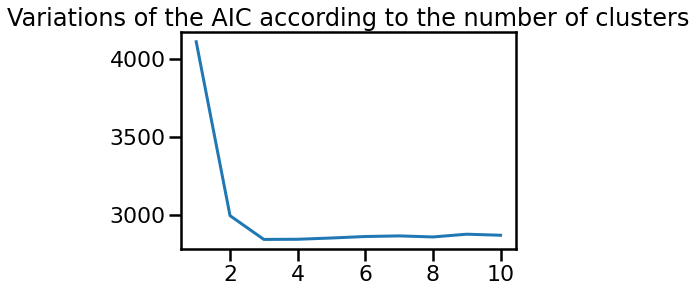

The best value of the AIC is: 2842.708559027076which corresponds to 3 clusters
The computation time is 7.380872011184692 s


In [23]:
t0 = time()
AIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "kmeans")
    GMM.fit(X_model_1)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    AIC = AIC_criterion(mu, Sigma, alpha, X_model_1)
    print('The value of the AIC for ' + str(l)+ ' clusters is AIC = '+ str(AIC))
    AIC_crit.append(AIC)
    
plt.plot([i for i in range(1, len(AIC_crit)+1)], AIC_crit)
plt.title('Variations of the AIC according to the number of clusters')
plt.show()
AIC_best = min(AIC_crit)
print('The best value of the AIC is: ' + str(AIC_best) + 'which corresponds to ' + str(AIC_crit.index(AIC_best)+1) + ' clusters')

print('The computation time is ' + str(time() - t0) + ' s')

#### BIC Criterion Tests

The value of the AIC for 1 clusters is AIC = 4139.855306624129
The value of the AIC for 2 clusters is AIC = 3058.503267283602
The value of the AIC for 3 clusters is AIC = 2938.4097869776997
The value of the AIC for 4 clusters is AIC = 2971.2744183539826
The value of the AIC for 5 clusters is AIC = 3011.256494442231
The value of the AIC for 6 clusters is AIC = 3052.731463655095
The value of the AIC for 7 clusters is AIC = 3088.542566953255
The value of the AIC for 8 clusters is AIC = 3125.823849177755
The value of the AIC for 9 clusters is AIC = 3165.71914395437
The value of the AIC for 10 clusters is AIC = 3188.396388209943


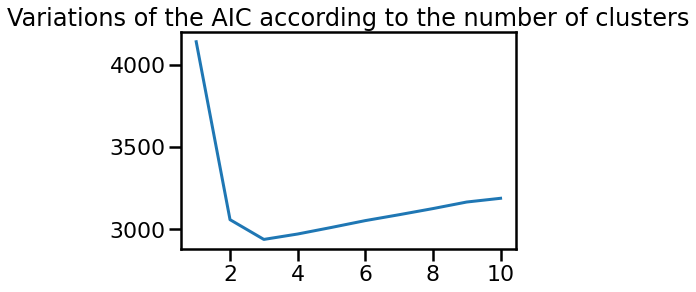

The best value of the AIC is: 2938.4097869776997which corresponds to 3 clusters
The computation time is 7.158892869949341 s


In [24]:
t0 = time()
BIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "kmeans")
    GMM.fit(X_model_1)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    BIC = BIC_criterion(mu, Sigma, alpha, X_model_1)
    print('The value of the AIC for ' + str(l)+ ' clusters is AIC = '+ str(BIC))
    BIC_crit.append(BIC)
    
plt.plot([i for i in range(1, len(BIC_crit)+1)], BIC_crit)
plt.title('Variations of the AIC according to the number of clusters')
plt.show()
BIC_best = min(BIC_crit)
print('The best value of the AIC is: ' + str(BIC_best) + 'which corresponds to ' + str(BIC_crit.index(BIC_best)+1) + ' clusters')

print('The computation time is ' + str(time() - t0) + ' s')

Both the AIC and BIC give us a number of clusters equal to 3. According to the plot of the data we can see that there are two clusters with a point that is an outlier. Thus BIC and AIC have considered this point as a cluster by itself.


The computational time to compute the AIC and BIC are very similar.

In [78]:
gmm = my_GMM(k=7, initialization = 'kmeans')    
gmm.fit(X_model_1)

In [42]:
t0 = time()
label = moder_order_selection(X_model_1,gmm,eps = 2,K=7, criterion = "distance")
print(len(np.unique(label)))
print('The computation time is ' + str(time() - t0) + ' s')

2
The computation time is 0.008978605270385742 s


In [51]:
t0 = time()
label = moder_order_selection(X_model_1,gmm,eps = 0.1, K=7, criterion = "parameter")
print(len(np.unique(label)))
print('The computation time is ' + str(time() - t0) + ' s')

2
The computation time is 0.010939598083496094 s


The order selection model does not take into account the outlier and predicts two clusters. This method is very fast.

### Data_MM_2

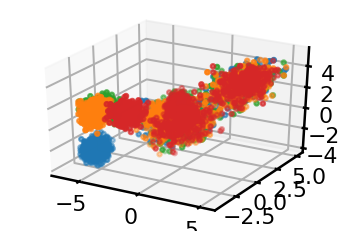

In [30]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
data_MM_2 = pd.read_csv('data_MM_2.csv', names = ['C1', 'C2', 'C3', 'C4'])
threedee = plt.figure().gca(projection='3d')
threedee.scatter(data_MM_2['C1'], data_MM_2['C2'], data_MM_2['C3'])
threedee.scatter(data_MM_2['C1'], data_MM_2['C2'], data_MM_2['C4'])
threedee.scatter(data_MM_2['C1'], data_MM_2['C3'], data_MM_2['C4'])
threedee.scatter(data_MM_2['C2'], data_MM_2['C3'], data_MM_2['C4'])
plt.show()

In [31]:
X_model_2 = data_MM_2[["C1", "C2", "C3", "C4"]].to_numpy() 
print(X_model_2)
n, p = X_model_2.shape

[[-5.54756729 -2.84666605 -2.42803785  1.15333554]
 [ 2.9064721   2.82478726  2.53865624  2.94265361]
 [-5.31567352 -2.82217776 -2.31536358  2.20563892]
 ...
 [-1.48460186 -0.92517901 -1.15264264 -0.0229337 ]
 [ 1.06096371  0.17658467  0.49517688 -0.43894492]
 [-5.23771429 -3.40283589 -1.57559156  1.62539381]]


#### AIC Criterion Tests

The value of the AIC for 1 clusters is AIC = 9511.168140077945
The value of the AIC for 2 clusters is AIC = 7834.861345015219
The value of the AIC for 3 clusters is AIC = 7355.3775030241395
The value of the AIC for 4 clusters is AIC = 7122.027667408527
The value of the AIC for 5 clusters is AIC = 7133.699937830769
The value of the AIC for 6 clusters is AIC = 7140.850323519544
The value of the AIC for 7 clusters is AIC = 7150.1289611963
The value of the AIC for 8 clusters is AIC = 7159.89228342356
The value of the AIC for 9 clusters is AIC = 7163.278899566849
The value of the AIC for 10 clusters is AIC = 7162.583308799041


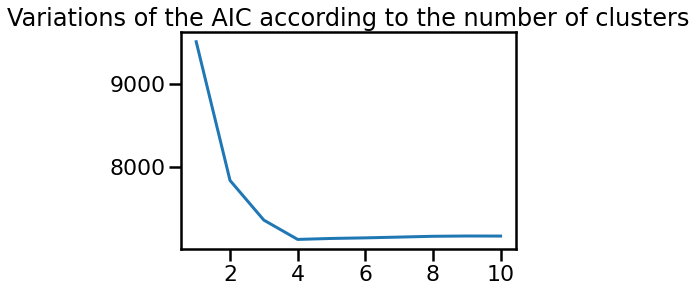

The best value of the AIC is: 7122.027667408527which corresponds to 4 clusters
The computation time is 5.580913543701172 s


In [32]:
t0 = time()
AIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "kmeans")
    GMM.fit(X_model_2)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    AIC = AIC_criterion(mu, Sigma, alpha, X_model_2)
    print('The value of the AIC for ' + str(l)+ ' clusters is AIC = '+ str(AIC))
    AIC_crit.append(AIC)
    
plt.plot([i for i in range(1, len(AIC_crit)+1)], AIC_crit)
plt.title('Variations of the AIC according to the number of clusters')
plt.show()
AIC_best = min(AIC_crit)
print('The best value of the AIC is: ' + str(AIC_best) + 'which corresponds to ' + str(AIC_crit.index(AIC_best)+1) + ' clusters')
print('The computation time is ' + str(time() - t0) + ' s')

#### BIC Criterion Tests

The value of the BIC for 1 clusters is BIC = 9566.956954142393
The value of the BIC for 2 clusters is BIC = 7946.438973144115
The value of the BIC for 3 clusters is BIC = 7522.743945217484
The value of the BIC for 4 clusters is BIC = 7345.182923666154
The value of the BIC for 5 clusters is BIC = 7408.438747317583
The value of the BIC for 6 clusters is BIC = 7475.5832078042895
The value of the BIC for 7 clusters is BIC = 7540.6505605621105
The value of the BIC for 8 clusters is BIC = 7606.202791054018
The value of the BIC for 9 clusters is BIC = 7665.378238266349
The value of the BIC for 10 clusters is BIC = 7729.341676031555


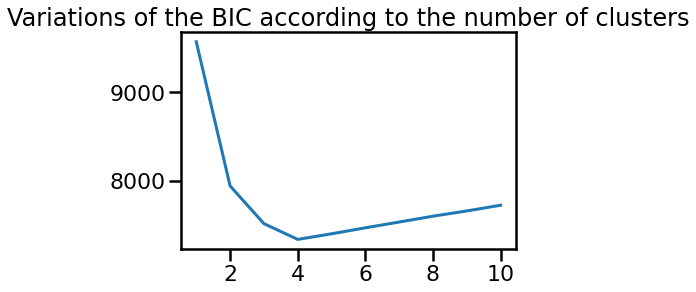

The best value of the BIC is: 7345.182923666154which corresponds to 4 clusters
The computation time is 5.074558973312378 s


In [33]:
t0 = time()
BIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "kmeans")
    GMM.fit(X_model_2)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    BIC = BIC_criterion(mu, Sigma, alpha, X_model_2)
    print('The value of the BIC for ' + str(l)+ ' clusters is BIC = '+ str(BIC))
    BIC_crit.append(BIC)
    
plt.plot([i for i in range(1, len(BIC_crit)+1)], BIC_crit)
plt.title('Variations of the BIC according to the number of clusters')
plt.show()
BIC_best = min(BIC_crit)
print('The best value of the BIC is: ' + str(BIC_best) + 'which corresponds to ' + str(BIC_crit.index(BIC_best)+1) + ' clusters')
print('The computation time is ' + str(time() - t0) + ' s')

According to the 3D plots of the data, we can see that there are either 3 or 4 clusters. Both AIC and BIC predict 4 clusters which is coherent with the above plots.

Once again the computational time is similar between the AIC and the BIC.

In [55]:
gmm = my_GMM(k=7, initialization = 'kmeans')    
gmm.fit(X_model_2)

In [57]:
t0 = time()
label = moder_order_selection(X_model_2,gmm,eps = 3,K = 7, criterion = "distance")
print(len(np.unique(label)))
print('The computation time is ' + str(time() - t0) + ' s')

3
The computation time is 0.007978439331054688 s


In [64]:
t0 = time()
label = moder_order_selection(X_model_2,gmm,eps = 1, K=7, criterion = "parameter")
print(len(np.unique(label)))
print('The computation time is ' + str(time() - t0) + ' s')

3
The computation time is 0.016924142837524414 s


The model order selection gives 3 clusters which is also coherent. It is hard to determine the exact number of clusters just by looking at the 3D plots as the data is 4 dimensional. This method is very fast.

## Application

You are going to work with the following data:

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
shape: (1797, 64)


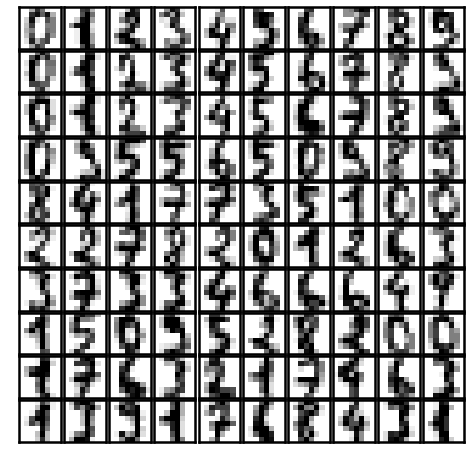

In [4]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data)
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Model your data with your GMM class using a model order selection method to produce new synthetic handwritten numbers. Explain why you used that model selection method in this case. Finally, sample from every class and visualize to get an idea of what each cluster corresponds to. You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

In [5]:
def permute(predicted,i,j):
    i_temp = -1

    p=np.where(predicted==i, i_temp, predicted)
    p = np.where(p==j,i,p)
    p = np.where(p==-1,j,p)
    return p
def change_labels(predicted,true):
    # We will try to change the labels in a way to increase the accuracy:
    accuracy = accuracy_score(predicted, true)
    for i in range(10):
        for j in range(10):
            predicted_temp = permute(predicted, i,j)
            accuracy_temp = accuracy_score(predicted_temp, true)
            if accuracy_temp>accuracy:
                accuracy = accuracy_temp
                predicted = predicted_temp
    return predicted

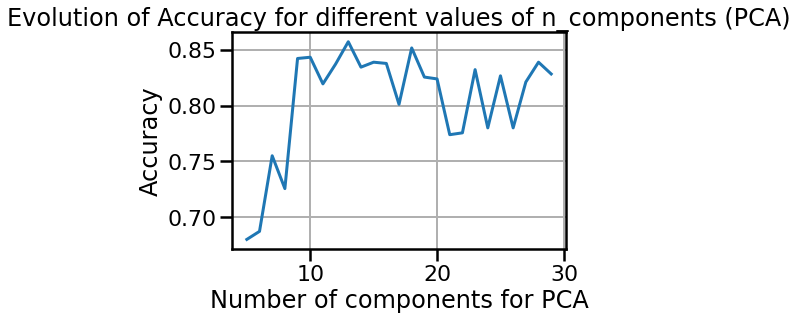

In [18]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
data = digits.data
n,p = data.shape
number_digits = 10
labels = digits.target
Acc = []
x = list(range(5,30))
for dim_red in range(5,30):
    pca = PCA(n_components = dim_red)
    data_reduced = pca.fit_transform(data)
    model = my_GMM(k=10, initialization = 'kmeans')
    data_bis = model.fit(data_reduced)
    pred_labels = model.predict(data_reduced)
    predicted_labels = change_labels(pred_labels, labels)
    Acc.append(accuracy_score(predicted_labels, labels))

plt.title('Evolution of Accuracy for different values of n_components (PCA)')
plt.xlabel('Number of components for PCA')
plt.ylabel('Accuracy')
plt.grid()
plt.plot(x,Acc)
plt.show()

We can see that there is a peak accuracy at n_components = 15. Thus we choose 15 as the dimension of the lower dimensional space chosen for the reduction.

In [8]:
pca = PCA(n_components = 15)
data_reduced = pca.fit_transform(data)
print(data_reduced.shape)

(1797, 15)


### BIC testing

The value of the BIC for 5 clusters is BIC = 88162.48395772872
The value of the BIC for 6 clusters is BIC = 87447.55799514847
The value of the BIC for 7 clusters is BIC = 87452.5706382538
The value of the BIC for 8 clusters is BIC = 87394.88426836794
The value of the BIC for 9 clusters is BIC = 87509.61488107321
The value of the BIC for 10 clusters is BIC = 87886.18569788395
The value of the BIC for 11 clusters is BIC = 88395.76655274899
The value of the BIC for 12 clusters is BIC = 88648.41429988797
The value of the BIC for 13 clusters is BIC = 89102.42274866236
The value of the BIC for 14 clusters is BIC = 89641.54619676404
The value of the BIC for 15 clusters is BIC = 90162.58122802338
The value of the BIC for 16 clusters is BIC = 90687.85087725334
The value of the BIC for 17 clusters is BIC = 91269.21740644233
The value of the BIC for 18 clusters is BIC = 91942.79418429987
The value of the BIC for 19 clusters is BIC = 92731.66247009134


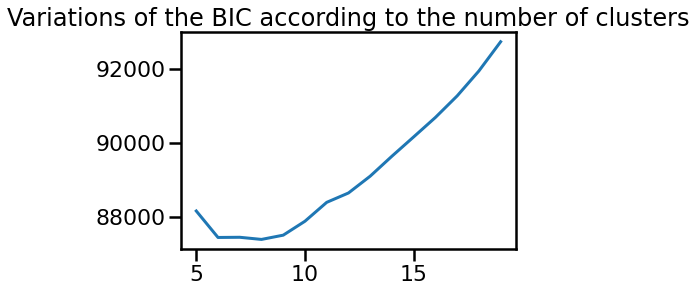

The best value of the BIC is: 87394.88426836794which corresponds to 8 clusters


In [17]:
BIC_crit = []

k_values = [i for i in range(5,20)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "kmeans")
    GMM.fit(data_reduced)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    BIC = BIC_criterion(mu, Sigma, alpha, data_reduced)
    print('The value of the BIC for ' + str(l)+ ' clusters is BIC = '+ str(BIC))
    BIC_crit.append(BIC)
    
plt.plot(k_values, BIC_crit)
plt.title('Variations of the BIC according to the number of clusters')
plt.show()
BIC_best = min(BIC_crit)
print('The best value of the BIC is: ' + str(BIC_best) + 'which corresponds to ' + str(k_values[BIC_crit.index(BIC_best)]) + ' clusters')

We can see that the model selected by the BIC criterion is 8. The given dataset actually has 10 clusters but we can explain this difference by the fact that the BIC wants to minimize the log-likelihood while keeping the model as simple as possible.

In [ ]:
label = moder_order_selection(X_model_2,gmm,eps = 3,K = 5, criterion = "distance")